In [1]:
%load_ext autoreload
%autoreload 2

from aqua import Reader
from teleconnections import Teleconnection

The notebook evaluate the ENSO index with the class method well tested from teleconnections and the new developed fldmean possibility of taking a box as arguments of the method.
A comparison plot is shown at the bottom.

In [2]:
# Setup source to be analysed

model = 'ERA5'
exp = 'era5'
source = 'monthly'

In [3]:
# Case 1: tc class

tc = Teleconnection(model=model, exp=exp, source=source, telecname='ENSO')
tc.evaluate_index()

2023-08-23 12:13:04 :: Teleconnection :: WARNING  -> No regridding will be performed
2023-08-23 12:13:04 :: Teleconnection :: WARNING  -> No time aggregation will be performed


2023-08-23 12:13:13 :: Teleconnection :: WARNING  -> No retrieve has been performed, trying to retrieve
/work/bb1153/b382289/mambaforge/envs/aqua_common/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 83 times more chunks
  return self.array[key]


In [4]:
# Case 2: fldmean from reader (WIP)
reader = Reader(model=model, exp=exp, source=source, loglevel='DEBUG')
data = reader.retrieve(var='sst')
data

2023-08-23 12:13:34 :: Reader :: INFO     -> Updating the log_level to DEBUG
2023-08-23 12:13:34 :: Streaming :: INFO     -> Updating the log_level to DEBUG
2023-08-23 12:13:34 :: Reader :: INFO     -> Retrieving variables: ['sst']
2023-08-23 12:13:34 :: Reader :: DEBUG    -> Variables in the fixes: {'2t': {'grib': True, 'source': 'T2M'}, 'msl': {'grib': True, 'source': 'MSL'}, 'erate': {'grib': True, 'source': 'E', 'src_units': 'm/day', 'units': 'kg m**-2 s**-1'}, 'tprate': {'grib': True, 'source': 'TP', 'src_units': 'm/day'}, 'tcc': {'grib': True, 'source': 'TCC'}, 'sst': {'grib': True, 'source': 'SSTK'}, 'mslhfl': {'src_units': 'J m**-2 day**-1', 'source': 'SLHF', 'grib': True}, 'msshfl': {'src_units': 'J m**-2 day**-1', 'source': 'SSHF', 'grib': True}, 'msnsrf': {'src_units': 'J m**-2 day**-1', 'source': 'SSR', 'grib': True}, 'msdsrf': {'src_units': 'J m**-2 day**-1', 'source': 'SSRD', 'grib': True}, 'msntrf': {'src_units': 'J m**-2 day**-1', 'source': 'STR', 'grib': True}, 'msdtrf

<xarray.Dataset>
Dimensions:  (time: 996, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Thu May 25 12:09:12 2023: cdo -O -s -f nc4 -z zip -shifttim...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

In [6]:
# retrieving box coordinates
from teleconnections.tools import TeleconnectionsConfig

config = TeleconnectionsConfig()
namelist = config.load_namelist()

lon_limit = namelist['ENSO']['lonW'], namelist['ENSO']['lonE']
lat_limit = namelist['ENSO']['latS'], namelist['ENSO']['latN']

print(lon_limit, lat_limit)
field = namelist['ENSO']['field']

(-170, -120) (-5, 5)


In [7]:
data_wgt = reader.fldmean(data=data, lon_limits=lon_limit, lat_limits=lat_limit)

2023-08-23 12:15:11 :: Reader :: WARNING  -> lat is sorted in different way between area files and your dataset. Flipping it!


In [8]:
# Index evaluation
field_mean_an = data_wgt[field].groupby("time.month") - data_wgt[field].groupby("time.month").mean(dim="time")
field_mean_an = field_mean_an.rolling(time=3, center=True).mean(skipna=True)

/work/bb1153/b382289/mambaforge/envs/aqua_common/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 83 times more chunks
  return self.array[key]


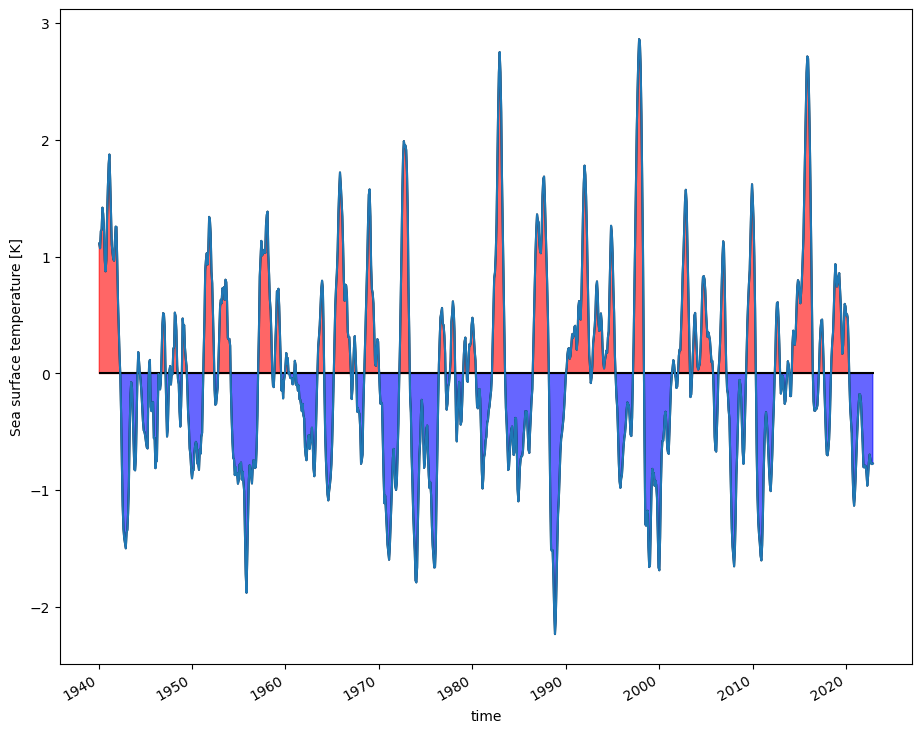

In [9]:
tc.plot_index()
field_mean_an.plot()